In [10]:
import geopandas as gpd
import pandas as pd
from siuba import *

# project sources

## dropped/excluded

* US 50 (withdrawn)
* US 101 Marin (minimal accessibility/speed benefits, worthwhile project better analyzed in another context)
* MST reroute (apparent marginal/negative benefits, institutional barriers to relocating/adding service)

# read and aggregate

In [11]:
first_set = gpd.read_file('./june16_corridor_metrics_speeds.geojson')
first_set = first_set >> filter(-_.corridor.str.contains('us50')) #dropped
first_set['submission_round'] = 1

In [12]:
(first_set >> select(-_.geometry)).to_csv('pending_accessibility.csv')

In [13]:
second_set = gpd.read_file('./sep9_corridor_metrics_speeds.geojson')
second_set['submission_round'] = 2

In [14]:
access_results = pd.read_csv('./AccessibilityResults.csv')

In [15]:
first_set >> head(3)

,route_id,route_short_name,organization,p20_corr_mph,p50_corr_mph,avg_corr_mph,speed_delay_minutes,total_speed_delay,p50_runtime_minutes,n_trips,span_hours,daily_avg_trips_hr,trips_added,new_avg_trips_hr,length_miles,distance_meters,target_mph,corridor,geometry,submission_round
0,28,28,City and County of San Francisco,9.3,11.8,13.2,480.1,1690.8,56.4,159,14.9,5.3,8.5,5.6,1.1,1739.0,16,us101_lombard,"POLYGON ((-214489.679 -21257.665, -214484.673 ...",1
1,43,43,City and County of San Francisco,8.1,9.5,10.1,1210.7,1690.8,73.2,143,14.8,4.8,16.5,5.4,1.1,NaN,16,us101_lombard,"POLYGON ((-214489.679 -21257.665, -214484.673 ...",1
2,28,28,City and County of San Francisco,9.6,11.5,11.9,1061.7,1347.9,56.4,159,14.9,5.3,18.8,6.0,2.4,3850.5,16,sr1_19th_a,"POLYGON ((-217949.193 -26918.889, -217955.214 ...",1


In [16]:
second_set >> head(3)

,route_id,route_short_name,organization,p20_corr_mph,p50_corr_mph,avg_corr_mph,speed_delay_minutes,total_speed_delay,p50_runtime_minutes,n_trips,span_hours,daily_avg_trips_hr,trips_added,new_avg_trips_hr,length_miles,distance_meters,target_mph,corridor,geometry,submission_round
0,4-13168,4,Los Angeles County Metropolitan Transportation...,4.7,11.1,9.3,94.2,94.2,96.2,33,2.3,7.2,1.0,7.4,1.2,1982.4,16,sr2_am,"POLYGON ((140814.209 -441265.975, 140892.548 -...",2
1,4-13168,4,Los Angeles County Metropolitan Transportation...,4.9,6.8,7.9,342.4,342.4,153.5,42,3.1,6.7,2.2,7.1,1.3,2105.6,16,sr2_pm,"POLYGON ((140814.209 -441265.975, 140892.548 -...",2
2,4-13168,4,Los Angeles County Metropolitan Transportation...,3.4,8.8,7.8,685.4,685.4,131.2,111,6.9,8.0,5.2,8.4,1.3,2105.6,16,sr2_mid,"POLYGON ((140814.209 -441265.975, 140892.548 -...",2


In [17]:
all_corridors = pd.concat([first_set, second_set])

In [18]:
all_grouped = (all_corridors >> group_by(_.corridor, _.organization, _.submission_round)  # length and span cause fan-out, re-add later...
               >> summarize(sum_trips =_.n_trips.sum(), total_delay = _.total_speed_delay.max())
               >> mutate(avg_delay_minutes = _.total_delay / _.sum_trips)
)

## note: don't sum/aggregate accessibility results within a corridor

In [19]:
rider_access_joined = all_grouped >> left_join(_, access_results, on=['corridor', 'submission_round'])

# Adding ridership (added to accessibility csv)

## apportioning ridership for partial-hour bus lane on sr2

* evenly during daytime hours (0500 - 2200), match post-covid trends of less peaking
* 22,669 daily for entire corr
* 

## notes
* for SDMTS, sum ridership from routes 60, 235, 225

In [20]:
metro_4_ridership = 22669
riders_per_hour = metro_4_ridership / (22 - 5)

In [21]:
rider_estimates = (second_set >> filter(_.corridor.str.contains('sr2'))
 >> select(_.corridor, _.span_hours, _.submission_round)
 >> mutate(daily_riders = _.span_hours * riders_per_hour)
 >> select(-_.span_hours)
)
rider_estimates

,corridor,submission_round,daily_riders
0,sr2_am,2,3066.982353
1,sr2_pm,2,4133.758824
2,sr2_mid,2,9200.947059
3,sr2_eve,2,3467.023529
4,sr2_early_am,2,1333.470588


In [22]:
rider_access_joined = rider_access_joined >> left_join(_, rider_estimates, on =['corridor', 'submission_round'])

In [23]:
rider_access_joined['daily_riders'] = rider_access_joined.daily_riders_x.fillna(rider_access_joined.daily_riders_y)

In [24]:
rider_access_joined = rider_access_joined >> select(-_.daily_riders_x, -_.daily_riders_y)

# Create defined projects from disaggregated sr2

In [25]:
df = rider_access_joined >> filter(_.corridor.str.contains('sr2'), _.submission_round == 2)

In [26]:
df

,corridor,organization,submission_round,sum_trips,total_delay,avg_delay_minutes,avg_pct_chng_access,pct_change_access_Jobs,pct_change_access_weighted_Jobs,avg_change_access_Jobs,weighted_avg_change_access_Jobs,pct_change_access_POIs,pct_change_access_weighted_POIs,avg_change_access_POIs,weighted_avg_change_access_POIs,pct_li_sub50k,daily_riders
7,sr2_am,Los Angeles County Metropolitan Transportation...,2,33,94.2,2.854545,0.00165,0.001626,0.0017,195.925474,586.809451,0.001734,0.0016,2.475954,6.635036,0.83,3066.982353
8,sr2_early_am,Los Angeles County Metropolitan Transportation...,2,14,4.1,0.292857,0.00165,0.001626,0.0017,195.925474,586.809451,0.001734,0.0016,2.475954,6.635036,0.83,1333.470588
9,sr2_eve,Los Angeles County Metropolitan Transportation...,2,23,89.8,3.904348,0.00165,0.001626,0.0017,195.925474,586.809451,0.001734,0.0016,2.475954,6.635036,0.83,3467.023529
10,sr2_mid,Los Angeles County Metropolitan Transportation...,2,111,685.4,6.174775,0.00165,0.001626,0.0017,195.925474,586.809451,0.001734,0.0016,2.475954,6.635036,0.83,9200.947059
11,sr2_pm,Los Angeles County Metropolitan Transportation...,2,42,342.4,8.152381,0.00165,0.001626,0.0017,195.925474,586.809451,0.001734,0.0016,2.475954,6.635036,0.83,4133.758824


In [39]:
def df_combined(filtered_df, corridor):
    df2 = filtered_df[['sum_trips', 'total_delay', 'daily_riders']].sum()
    df2['avg_delay_minutes'] = df2.total_delay / df2.sum_trips
    df2['corridor'] = corridor
    df2_dict = df2.to_dict()
    unchanged_series = (filtered_df >> select(-_.sum_trips, -_.total_delay, -_.daily_riders, -_.avg_delay_minutes, -_.corridor)).iloc[0,:]
    unchanged_dict = unchanged_series.to_dict()
    merged_dict = df2_dict | unchanged_dict
    merged_df = pd.DataFrame(merged_dict, index=[99])
    return merged_df

In [40]:
all_day_df = df_combined(df, 'sr2_all_day')

In [41]:
peak_only_df = df_combined(df >> filter(_.corridor.isin(['sr2_am', 'sr2_pm'])), 'sr2_peak')

In [42]:
with_sr2 = pd.concat([rider_access_joined, all_day_df, peak_only_df]).reset_index(drop=True)

In [44]:
sr2_precursors = ['sr2_am', 'sr2_pm', 'sr2_early_am', 'sr2_eve', 'sr2_mid']

In [82]:
eval_df = with_sr2 >> filter(-_.corridor.isin(sr2_precursors))

# Testing metrics

In [83]:
eval_df.columns

Index(['corridor', 'organization', 'submission_round', 'sum_trips',
       'total_delay', 'avg_delay_minutes', 'avg_pct_chng_access',
       'pct_change_access_Jobs', 'pct_change_access_weighted_Jobs',
       'avg_change_access_Jobs', 'weighted_avg_change_access_Jobs',
       'pct_change_access_POIs', 'pct_change_access_weighted_POIs',
       'avg_change_access_POIs', 'weighted_avg_change_access_POIs',
       'pct_li_sub50k', 'daily_riders'],
      dtype='object')

In [84]:
# could average both jobs and pois...

In [85]:
eval_df = (eval_df >> mutate(rider_minutes_delay = _.avg_delay_minutes * _.daily_riders)
         >> select(_.corridor, _.organization, _.submission_round,
                   # _.pct_change_access_weighted_Jobs, _.weighted_avg_change_access_Jobs,
                   _.avg_pct_chng_access,
                   _.pct_li_sub50k, _.daily_riders, _.rider_minutes_delay
                  )
)

In [86]:
eval_df >> filter(_.daily_riders.isna())

,corridor,organization,submission_round,avg_pct_chng_access,pct_li_sub50k,daily_riders,rider_minutes_delay
3,sr15,San Diego Metropolitan Transit System,2,NaN,NaN,NaN,NaN
14,sr66_foothill,Foothill Transit,1,NaN,NaN,NaN,NaN
15,sr82_samtrans,San Mateo County Transit District,1,NaN,NaN,NaN,NaN
16,sr82_vta,Santa Clara Valley Transportation Authority,1,NaN,NaN,NaN,NaN
17,us101_broadway,City of Eureka,1,0.033167,NaN,NaN,NaN


In [87]:
eval_df = eval_df.dropna()

In [89]:
nineteenth = eval_df >> filter(_.corridor.str.contains('sr1_19th'))

In [90]:
nineteenth.rider_minutes_delay = nineteenth.rider_minutes_delay.sum()

/tmp/ipykernel_477/241002628.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [91]:
nineteenth.corridor = 'sr1_19th'

/tmp/ipykernel_477/2219053992.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [93]:
eval_df = pd.concat([eval_df >> filter(-_.corridor.str.contains('sr1_19th')), nineteenth.iloc[:1,:]])

In [94]:
eval_df

,corridor,organization,submission_round,avg_pct_chng_access,pct_li_sub50k,daily_riders,rider_minutes_delay
0,i805,San Diego Metropolitan Transit System,2,0.015327,0.79,4233.000000,4679.816667
1,sr123,Alameda-Contra Costa Transit District,2,0.001397,0.65,14789.000000,58885.881279
2,sr123_san_pablo,Alameda-Contra Costa Transit District,1,0.003879,0.65,14789.000000,214334.019200
6,sr1_lincoln,City of Santa Monica,1,0.002109,0.73,6200.000000,49918.086957
12,sr2_santa_monica_bl,Los Angeles County Metropolitan Transportation...,1,0.002238,0.83,22669.000000,177918.999177
13,sr39_beach,Orange County Transportation Authority,1,0.007266,0.89,5075.000000,85674.522901
18,us101_lombard,City and County of San Francisco,1,0.000345,0.70,8200.000000,45909.139073
19,sr2_all_day,Los Angeles County Metropolitan Transportation...,2,0.001650,0.83,21202.182353,115604.186202
20,sr2_peak,Los Angeles County Metropolitan Transportation...,2,0.001650,0.83,7200.741176,41917.914635
4,sr1_19th,City and County of San Francisco,1,0.003184,0.70,12100.000000,82255.014749


In [97]:
from scipy import stats
eval_df["pctile_access"] = eval_df.avg_pct_chng_access.map(lambda x: stats.percentileofscore(eval_df.avg_pct_chng_access, x))
eval_df["pctile_rider"] = eval_df.daily_riders.map(lambda x: stats.percentileofscore(eval_df.daily_riders, x))
eval_df["pctile_rider_delay"] = eval_df.rider_minutes_delay.map(lambda x: stats.percentileofscore(eval_df.rider_minutes_delay, x))

In [99]:
eval_df['total_score'] = eval_df.pctile_access + eval_df.pctile_rider + eval_df.pctile_rider_delay
eval_df >> arrange(-_.total_score)

,corridor,organization,submission_round,avg_pct_chng_access,pct_li_sub50k,daily_riders,rider_minutes_delay,pctile_access,pctile_rider,pctile_rider_delay,total_score
2,sr123_san_pablo,Alameda-Contra Costa Transit District,1,0.003879,0.65,14789.000000,214334.019200,80.0,75.0,100.0,255.0
12,sr2_santa_monica_bl,Los Angeles County Metropolitan Transportation...,1,0.002238,0.83,22669.000000,177918.999177,60.0,100.0,90.0,250.0
19,sr2_all_day,Los Angeles County Metropolitan Transportation...,2,0.001650,0.83,21202.182353,115604.186202,35.0,90.0,80.0,205.0
4,sr1_19th,City and County of San Francisco,1,0.003184,0.70,12100.000000,82255.014749,70.0,60.0,60.0,190.0
13,sr39_beach,Orange County Transportation Authority,1,0.007266,0.89,5075.000000,85674.522901,90.0,20.0,70.0,180.0
1,sr123,Alameda-Contra Costa Transit District,2,0.001397,0.65,14789.000000,58885.881279,20.0,75.0,50.0,145.0
0,i805,San Diego Metropolitan Transit System,2,0.015327,0.79,4233.000000,4679.816667,100.0,10.0,10.0,120.0
6,sr1_lincoln,City of Santa Monica,1,0.002109,0.73,6200.000000,49918.086957,50.0,30.0,40.0,120.0
20,sr2_peak,Los Angeles County Metropolitan Transportation...,2,0.001650,0.83,7200.741176,41917.914635,35.0,40.0,20.0,95.0
18,us101_lombard,City and County of San Francisco,1,0.000345,0.70,8200.000000,45909.139073,10.0,50.0,30.0,90.0


In [ ]:
# percentile rank/combine on accessibility, riders, delay
# note accessibility carry over...
# note rural projects
# drop lombard (existing HOV, operations...)
# if time, try normalization (distance from project description..., use average change access?)

<AxesSubplot:xlabel='weighted_avg_change_access_Jobs', ylabel='daily_riders'>

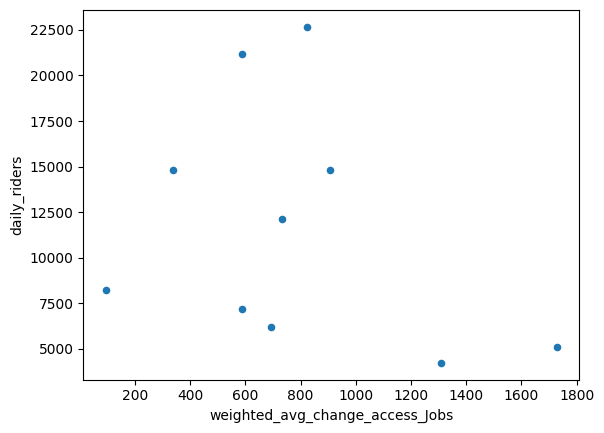

In [79]:
eval_df.plot.scatter("weighted_avg_change_access_Jobs", "daily_riders")

<AxesSubplot:xlabel='pct_change_access_weighted_Jobs', ylabel='rider_minutes_delay'>

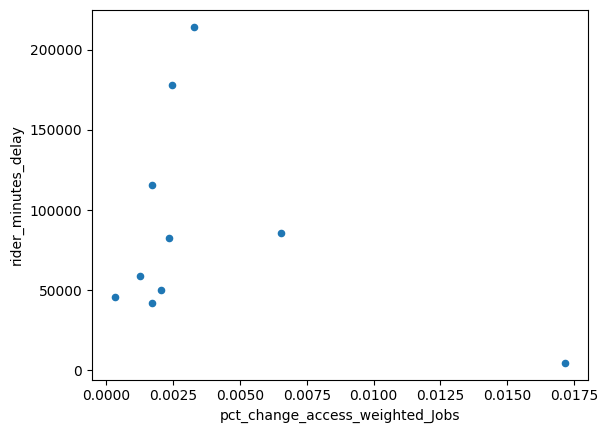

In [77]:
eval_df.plot.scatter("pct_change_access_weighted_Jobs", "rider_minutes_delay")

In [76]:
from plotnine import ggplot, aes, geom_point

(eval_df
  # >> mutate(hp_per_cyl = _.hp / _.cyl)
  >> ggplot(aes("pct_change_access_weighted_Jobs", "rider_minutes_delay"))
   + geom_point()
)

ImportError: cannot import name 'multitype_sort' from 'mizani.utils' (/opt/conda/lib/python3.9/site-packages/mizani/utils.py)

In [73]:
eval_df.describe()

,submission_round,pct_change_access_weighted_Jobs,weighted_avg_change_access_Jobs,pct_li_sub50k,daily_riders,rider_minutes_delay
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1.400000,0.003881,779.587921,0.760000,11645.792353,87709.758084
std,0.516398,0.004956,464.918119,0.084853,6601.472325,64962.030224
min,1.000000,0.000308,94.315690,0.650000,4233.000000,4679.816667
25%,1.000000,0.001700,586.809451,0.700000,6450.185294,46911.376044
50%,1.000000,0.002195,712.957360,0.760000,10150.000000,70570.448014
75%,2.000000,0.003067,884.828801,0.830000,14789.000000,108121.770376
max,2.000000,0.017178,1727.936813,0.890000,22669.000000,214334.019200


In [74]:
# or don't rank...
def li_score(x):
    if x > .8: return 5
    elif x > .7: return 4
    elif x > .6: return 3